In [1]:
words = open("names.txt","r").read().splitlines()
len(words)

32033

In [3]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
import torch

In [5]:
block_size = 3

def build_datasets(words):
    X,Y =[],[]
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [7]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])
Xdev, Ydev = build_datasets(words[n1:n2])
Xte, Yte = build_datasets(words[n2:])

In [8]:
Xtr.shape, Ytr.shape, Xdev.shape, Ydev.shape, Xte.shape, Yte.shape

(torch.Size([182580, 3]),
 torch.Size([182580]),
 torch.Size([22767, 3]),
 torch.Size([22767]),
 torch.Size([22799, 3]),
 torch.Size([22799]))

In [9]:
vocab_size = len(itos)

In [91]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)*(5/3)/(n_embd*block_size)**0.5
b1 = torch.randn(n_hidden,generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),generator=g) * 0.01
b2= torch.randn(vocab_size,generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
parameters = [C,W1,b1,W2,b2,bngain,bnbias]
for p in parameters:
    p.requires_grad=True

In [92]:
import torch.nn.functional as F

In [93]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
    Xb, Yb = Xtr[ix],Ytr[ix]
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)/hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,Yb)

    for p in parameters:
        p.grad =None
    
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000==0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3089
  10000/ 200000: 2.4859
  20000/ 200000: 2.4121
  30000/ 200000: 1.9830
  40000/ 200000: 2.0501
  50000/ 200000: 2.3730
  60000/ 200000: 2.2154
  70000/ 200000: 2.0275
  80000/ 200000: 1.9731
  90000/ 200000: 2.0637
 100000/ 200000: 2.4199
 110000/ 200000: 2.1416
 120000/ 200000: 2.1249
 130000/ 200000: 2.3267
 140000/ 200000: 2.2101
 150000/ 200000: 2.3471
 160000/ 200000: 2.0846
 170000/ 200000: 1.9970
 180000/ 200000: 2.3847
 190000/ 200000: 1.8819


In [78]:
logits[0]

tensor([0.6798, 0.6714, 0.6589, 0.5946, 0.6052, 0.6330, 0.6160, 0.6521, 0.6280,
        0.6553, 0.6248, 0.6440, 0.6661, 0.5960, 0.6129, 0.6233, 0.6205, 0.6650,
        0.6735, 0.6728, 0.6902, 0.6498, 0.6553, 0.6621, 0.6269, 0.5999, 0.6337],
       grad_fn=<SelectBackward0>)

(array([  1.,   0.,   0.,   3.,   0.,   5.,   4.,   3.,   5.,   4.,   7.,
         10.,   8.,  19.,  16.,  70.,  57.,  52.,  84., 125., 109., 150.,
        214., 245., 279., 268., 240., 309., 358., 336., 331., 331., 391.,
        313., 320., 329., 269., 234., 179., 186., 153., 140.,  73.,  67.,
         41.,  33.,  13.,  13.,   0.,   3.]),
 array([0.30801585, 0.31870644, 0.32939703, 0.34008761, 0.3507782 ,
        0.36146879, 0.37215938, 0.38284996, 0.39354055, 0.40423114,
        0.41492172, 0.42561231, 0.4363029 , 0.44699349, 0.45768407,
        0.46837466, 0.47906525, 0.48975583, 0.50044642, 0.51113701,
        0.5218276 , 0.53251818, 0.54320877, 0.55389936, 0.56458995,
        0.57528053, 0.58597112, 0.59666171, 0.60735229, 0.61804288,
        0.62873347, 0.63942406, 0.65011464, 0.66080523, 0.67149582,
        0.6821864 , 0.69287699, 0.70356758, 0.71425817, 0.72494875,
        0.73563934, 0.74632993, 0.75702051, 0.7677111 , 0.77840169,
        0.78909228, 0.79978286, 0.81047345, 0.

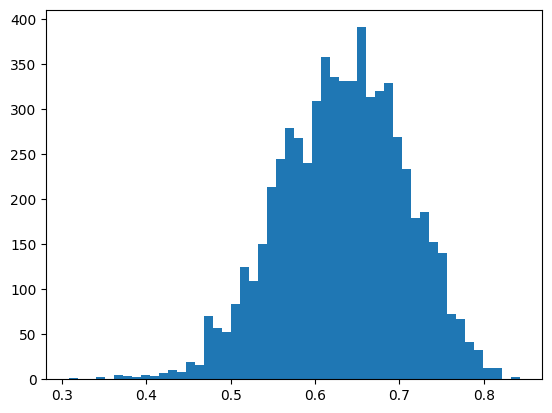

In [79]:
plt.hist(h.view(-1).tolist(),50) # if values are at 1 and -1 then it will lead to vanishing gradiant

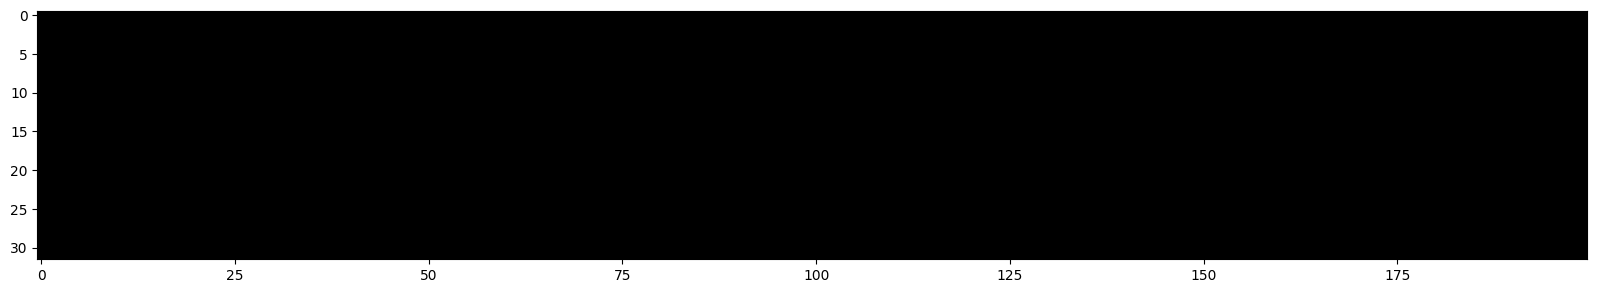

In [73]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray',interpolation='nearest')

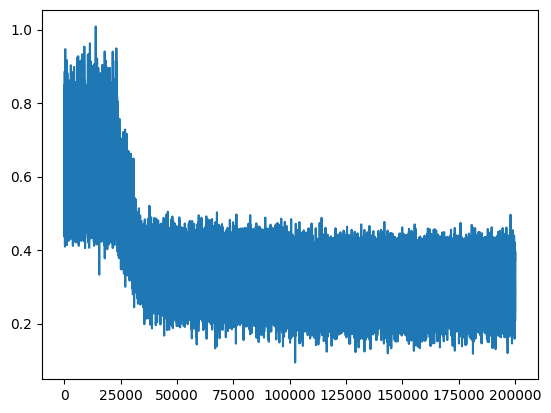

In [51]:
import matplotlib.pyplot as plt
plt.plot(lossi)

In [94]:
torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - hpreact.mean(0,keepdim=True)/hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.045185089111328
val 2.107642412185669


In [28]:
g = torch.Generator().manual_seed(21474783647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1)@W1+b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix ==0:
            break
    print(''.join(itos[i] for i in out))

uyaaas.
kdaeoazymk.
klceahn.
lj.
.
nnaueiaaaenrenlaayl.
.
yh.
ntszvm.
aaneeicla.
aalrnaaiceeyampsraoativioarsy.
e.
acaaeym.
iay.
hinai.
ailnaecaiejlrlafeuh.
eaykrdaiauniaiaednl.
.
dgrp.
nemareurts.


Kaiming init

tensor(0.0035) tensor(0.9851)
tensor(-0.0009) tensor(0.9922)


(array([2.12906645e-05, 2.12906645e-05, 0.00000000e+00, 2.12906645e-05,
        4.25813290e-05, 2.12906645e-05, 1.49034652e-04, 2.76778639e-04,
        4.25813290e-04, 6.81301264e-04, 1.42647452e-03, 2.44842642e-03,
        4.53491154e-03, 7.21753527e-03, 1.13692148e-02, 2.07158166e-02,
        3.20637407e-02, 4.71375312e-02, 7.38147338e-02, 1.05346208e-01,
        1.49354012e-01, 2.09010453e-01, 2.72371471e-01, 3.42800989e-01,
        3.94239235e-01, 4.24621013e-01, 4.27750741e-01, 3.97986392e-01,
        3.46228786e-01, 2.85124579e-01, 2.19315135e-01, 1.58870939e-01,
        1.11052106e-01, 7.60715443e-02, 4.96498296e-02, 3.28514953e-02,
        2.09925952e-02, 1.30298867e-02, 8.15432451e-03, 4.87556217e-03,
        2.57617041e-03, 1.66067183e-03, 8.94207909e-04, 3.61941297e-04,
        2.76778639e-04, 8.51626580e-05, 4.25813290e-05, 8.51626580e-05,
        2.12906645e-05, 4.25813290e-05]),
 array([-6.12273741, -5.88789269, -5.65304798, -5.41820327, -5.18335855,
        -4.94851384, 

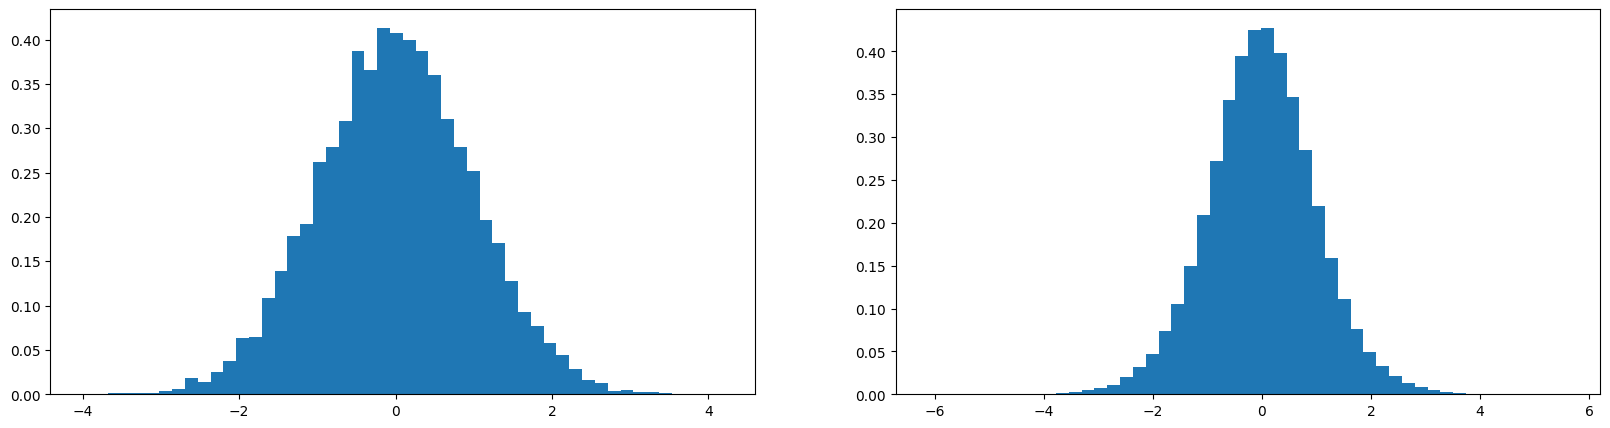

In [85]:
x = torch.randn(1000,10)
w = torch.randn(10,200) / 10**0.5
y = x@w
print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True)